# Motion Correction Tutorial

This Jupyter Notebook presents an example of the application of motion correction in T1 and DWI MRI images.


The motion correction algorithm uses Model-Driven Registration (MDR). `ukat` calls the python package `mdreg` and its source code can be found at: https://github.com/QIB-Sheffield/mdreg


Start by importing the required libraries and defining some settings:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from ukat.data import fetch
from ukat.utils.tools import convert_to_pi_range
from ukat.mapping.t1 import T1, magnitude_correct
from ukat.mapping.diffusion import ADC, DTI
from ukat.moco.mdr import MotionCorrection

# Ensure figures are rendered in the notebook
%matplotlib inline

# Initialise output path for the Model-Driven Registration process
directory = 'motion_correction_output'
os.makedirs(directory, exist_ok=True)
OUTPUT_DIR = os.path.join(os.getcwd(), directory)

Fetch UKRIN-MAPS T1 test data

In [2]:
magnitude, phase, affine_t1, ti, tss = fetch.t1_philips(2)
# Prepare the T1 modelling input arguments
phase = convert_to_pi_range(phase)
complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase)) # convert magnitude and phase into complex data
ti = np.array(ti) * 1000  # convert TIs to ms
magnitude_corrected = np.squeeze(magnitude_correct(complex_data))
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters_t1 = [affine_t1, ti, 0, None, None, 3, False]

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in log


In case you wish to test this with a different T1 dataset, see below a code snippet where a NIfTI file is read in Python.

```python
import nibabel as nib
image_file = os.path.join("C:\\{Users}\\{user}\\Desktop\\{folder}", "{file_name}.nii.gz")
magnitude_corrected = nib.load(image_file).get_fdata()
affine_t1 = nib.load(image_file).affine
ti = np.arange(0.1, 2.001, 0.1) * 1000  # convert TIs to ms
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters_t1 = [affine_t1, ti, 0, None, None, 3, False]
```

Fetch UKRIN-MAPS DWI test data

In [3]:
pixel_array, affine_dwi, bvals, bvecs = fetch.dwi_philips()
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters_dwi = [affine_dwi, bvals, None, False]

In case you wish to test this with a different DWI dataset, see below a code snippet where a NIfTI file is read in Python.

```python
import nibabel as nib
from dipy.io import read_bvals_bvecs
image_file = os.path.join("C:\\{Users}\\{user}\\Desktop\\{folder}", "{file_name}.nii.gz")
bvals_file = os.path.join("C:\\{Users}\\{user}\\Desktop\\{folder}", "{file_name}.bval")
bvecs_file = os.path.join("C:\\{Users}\\{user}\\Desktop\\{folder}", "{file_name}.bvec")
pixel_array = nib.load(image_file).get_fdata()
affine_dwi = nib.load(image_file).affine
bvals, bvecs = read_bvals_bvecs(bvals_file, bvecs_file)
# Pre-processing as preparation for the Model-Driven Registration process
list_input_parameters_dwi = [affine_dwi, bvals, None, False]
```

Set bounding box masks for motion correction

In [4]:
mask_flag = True
# The bounding box is set to 1/6 of the Field Of View (FOV). This ratio can be changed in the lines below.
if mask_flag == True:
    x_t1 = np.shape(magnitude_corrected)[0]
    y_t1 = np.shape(magnitude_corrected)[1]
    x_dwi = np.shape(pixel_array)[0]
    y_dwi = np.shape(pixel_array)[1]
    mask_moco_t1 = np.ones(np.shape(magnitude_corrected))
    mask_moco_dwi = np.ones(np.shape(pixel_array))
    mask_moco_t1[:int(x_t1/6), ...] = 0
    mask_moco_t1[int(5*x_t1/6):, ...] = 0
    mask_moco_t1[:, :int(y_t1/6), ...] = 0
    mask_moco_t1[:, int(5*y_t1/6):, ...] = 0
    mask_moco_dwi[:int(x_dwi/6), ...] = 0
    mask_moco_dwi[int(5*x_dwi/6):, ...] = 0
    mask_moco_dwi[:, :int(y_dwi/6), ...] = 0
    mask_moco_dwi[:, int(5*y_dwi/6):, ...] = 0
else:
    mask_moco_t1 = None
    mask_moco_dwi = None

## T1 Model-Driven Registration

Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16384/16384 [02:13<00:00, 122.64it/s]
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Finished fitting signal model (2.245908586184184 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:37<00:00,  2.09s/it]


Finished coregistration (0.628273077805837 min)
Finished MDR iteration 1 after 2.894039034843445 min
Improvement after MDR iteration 1: 1.324190816582221 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 16384/16384 [02:10<00:00, 125.26it/s]
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Finished fitting signal model (2.1993796825408936 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:34<00:00,  1.93s/it]


Finished coregistration (0.5780616442362467 min)
Finished MDR iteration 2 after 2.777557988961538 min
Improvement after MDR iteration 2: 0.3673450770571126 pixels
Fitting signal model..


100%|██████████| 16384/16384 [02:08<00:00, 127.73it/s]


Finished fitting signal model (2.1568515141805014 min)
Calculation time: 7.828481860955557 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16384/16384 [02:09<00:00, 126.16it/s]


Finished fitting signal model (2.1833699266115825 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:39<00:00,  2.20s/it]


Finished coregistration (0.6592114845911662 min)
Finished MDR iteration 1 after 2.8587918559710186 min
Improvement after MDR iteration 1: 1.2715938878618722 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 16384/16384 [02:12<00:00, 124.07it/s]
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Finished fitting signal model (2.2201555252075194 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:34<00:00,  1.91s/it]


Finished coregistration (0.5739109555880229 min)
Finished MDR iteration 2 after 2.794183146953583 min
Improvement after MDR iteration 2: 0.49899621622491236 pixels
Fitting signal model..


100%|██████████| 16384/16384 [02:11<00:00, 124.34it/s]


Finished fitting signal model (2.214763073126475 min)
Calculation time: 7.867788739999136 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16384/16384 [02:14<00:00, 122.25it/s]


Finished fitting signal model (2.2526556809743243 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:34<00:00,  1.94s/it]


Finished coregistration (0.581924565633138 min)
Finished MDR iteration 1 after 2.850703152020772 min
Improvement after MDR iteration 1: 0.8979032834925442 pixels
Fitting signal model..


100%|██████████| 16384/16384 [02:16<00:00, 119.88it/s]
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Finished fitting signal model (2.2967512369155885 min)
Calculation time: 5.147487847010295 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16384/16384 [02:16<00:00, 119.98it/s]


Finished fitting signal model (2.2945529858271283 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:34<00:00,  1.92s/it]


Finished coregistration (0.5758966247240702 min)
Finished MDR iteration 1 after 2.886967595418294 min
Improvement after MDR iteration 1: 1.1131003243066742 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 16384/16384 [02:17<00:00, 119.19it/s]
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Finished fitting signal model (2.3093472202618917 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:34<00:00,  1.94s/it]


Finished coregistration (0.5812025308609009 min)
Finished MDR iteration 2 after 2.89066637357076 min
Improvement after MDR iteration 2: 0.25850839133033804 pixels
Fitting signal model..


100%|██████████| 16384/16384 [02:17<00:00, 119.39it/s]


Finished fitting signal model (2.3054932951927185 min)
Calculation time: 8.08314395348231 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16384/16384 [02:22<00:00, 115.34it/s]


Finished fitting signal model (2.386180412769318 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 18/18 [00:34<00:00,  1.94s/it]


Finished coregistration (0.5823448657989502 min)
Finished MDR iteration 1 after 2.9847225308418275 min
Improvement after MDR iteration 1: 0.7016244255013017 pixels
Fitting signal model..


100%|██████████| 16384/16384 [02:24<00:00, 113.36it/s]
divide by zero encountered in double_scalars
divide by zero encountered in double_scalars


Finished fitting signal model (2.427146367232005 min)
Calculation time: 5.411885579427083 min


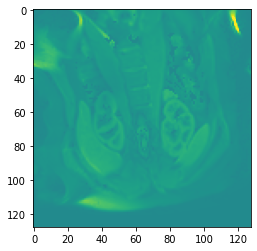

In [5]:
t1_registration = MotionCorrection(magnitude_corrected, affine_t1, 'T1_Moco', list_input_parameters_t1, convergence=1, multithread=False, log=False, mask=mask_moco_t1)

Extract and save the motion corrected T1 results.

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


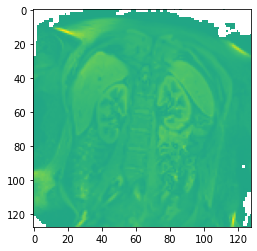

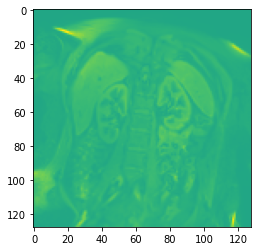

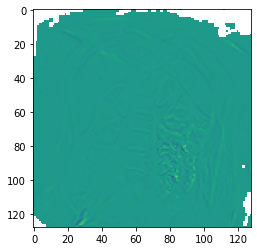

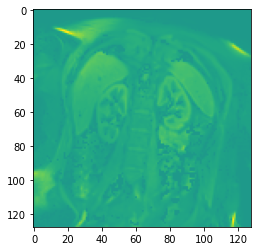

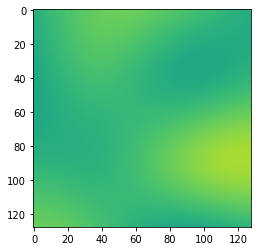

In [6]:
# Get the T1 coregistered pixel_array and the array with the difference between the original and the motion corrected
t1_moco_array = t1_registration.get_coregistered()
t1_moco_diff_array = t1_registration.get_diff_orig_coreg()
t1_registration.get_elastix_parameters(output_directory=OUTPUT_DIR, base_file_name='T1_Elastix', export=True)
t1_registration.get_improvements(output_directory=OUTPUT_DIR, base_file_name='T1_improvements', export=True)
# Save motion corrected T1 sequence to NIfTI
t1_registration.to_nifti(output_directory=OUTPUT_DIR, base_file_name='T1_motion_corrected', maps=['original', 'coregistered', 'difference', 'model_fit', 'mask', 'deformation_field', 'parameters'])
t1_registration.to_gif(output_directory=OUTPUT_DIR, base_file_name='T1_motion_corrected', maps=['original', 'coregistered', 'difference', 'model_fit', 'deformation_field'])

Perform T1 map calculation in the original and co-registered T1 images.

In [7]:
# Calculate maps from the original T1 sequence save as niftis
t1_mapper = T1(magnitude_corrected, ti, affine=affine_t1, multithread=False, parameters=3)
t1_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='T1_original', maps='all')

# Calculate maps from the motion corrected T1 sequence and save as niftis
t1_moco_mapper = T1(t1_moco_array, ti, affine=affine_t1, multithread=False, parameters=3)
t1_moco_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='T1_moco', maps='all')

100%|██████████| 77139/77139 [10:37<00:00, 120.94it/s]
divide by zero encountered in reciprocal
100%|██████████| 81920/81920 [11:24<00:00, 119.75it/s]


Display the difference between the original T1 images and the co-registered images.

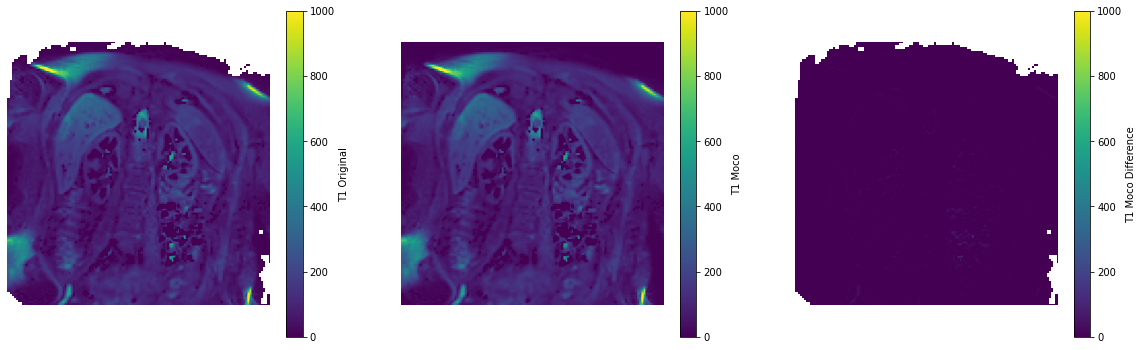

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Display the T1 original data
im = ax1.imshow(np.rot90(magnitude_corrected[..., 2, 10]), clim=(0, 1000))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('T1 Original')
ax1.axis('off')

# Display the T1 co-registered data
im2 = ax2.imshow(np.rot90(t1_moco_array[..., 2, 10]), clim=(0, 1000))
cb = fig.colorbar(im2, ax=ax2)
cb.set_label('T1 Moco')
ax2.axis('off')

# Display the difference image between T1 original data and T1 co-registered data
im3 = ax3.imshow(np.rot90(t1_moco_diff_array[..., 2, 10]), clim=(0, 1000))
cb = fig.colorbar(im3, ax=ax3)
cb.set_label('T1 Moco Difference')
ax3.axis('off')

plt.show()

Plot the T1 maps from the original and co-registered images.

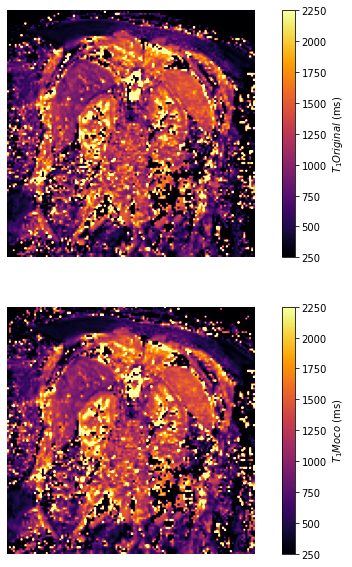

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Display the T1 map generated from the original data
im = ax1.imshow(np.rot90(t1_mapper.t1_map[..., 2]), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('$T_1 Original$ (ms)')
ax1.axis('off')

# Display the T1 map generated from the motion corrected data
im2 = ax2.imshow(np.rot90(t1_moco_mapper.t1_map[..., 2]), cmap='inferno', clim=(250, 2250))
cb = fig.colorbar(im2, ax=ax2)
cb.set_label('$T_1 Moco$ (ms)')
ax2.axis('off')

plt.show()

## DWI Model-driven registration

Starting MDR iteration 1
Fitting signal model..


100%|██████████| 15878/15878 [00:02<00:00, 7367.82it/s]


Finished fitting signal model (0.03690074682235718 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]


Finished coregistration (2.657776439189911 min)
Finished MDR iteration 1 after 2.74728410243988 min
Improvement after MDR iteration 1: 1.8480006804921278 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15874/15874 [00:02<00:00, 6840.50it/s]


Finished fitting signal model (0.03964322010676066 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:41<00:00,  2.04s/it]


Finished coregistration (2.688977388540904 min)
Finished MDR iteration 2 after 2.7291372497876485 min
Improvement after MDR iteration 2: 0.4463735205413863 pixels
Fitting signal model..


100%|██████████| 15860/15860 [00:02<00:00, 7160.09it/s]


Finished fitting signal model (0.03791755437850952 min)
Calculation time: 5.514355611801148 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 15906/15906 [00:02<00:00, 7231.39it/s]


Finished fitting signal model (0.03762633005777995 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:41<00:00,  2.04s/it]


Finished coregistration (2.683560832341512 min)
Finished MDR iteration 1 after 2.775425358613332 min
Improvement after MDR iteration 1: 2.696658305758661 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15984/15984 [00:02<00:00, 7376.08it/s]


Finished fitting signal model (0.03711755673090617 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:41<00:00,  2.04s/it]


Finished coregistration (2.6854817986488344 min)
Finished MDR iteration 2 after 2.723265202840169 min
Improvement after MDR iteration 2: 0.6088167795161068 pixels
Fitting signal model..


100%|██████████| 15985/15985 [00:02<00:00, 7134.32it/s]


Finished fitting signal model (0.03867634137471517 min)
Calculation time: 5.537400257587433 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 15898/15898 [00:02<00:00, 7232.75it/s]


Finished fitting signal model (0.03766764005025228 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:42<00:00,  2.05s/it]


Finished coregistration (2.705186172326406 min)
Finished MDR iteration 1 after 2.7982300162315368 min
Improvement after MDR iteration 1: 2.7162646911138593 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15921/15921 [00:02<00:00, 7264.61it/s]


Finished fitting signal model (0.03750917911529541 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:42<00:00,  2.06s/it]


Finished coregistration (2.706421415011088 min)
Finished MDR iteration 2 after 2.744463932514191 min
Improvement after MDR iteration 2: 0.5590226107087164 pixels
Fitting signal model..


100%|██████████| 15921/15921 [00:02<00:00, 7015.07it/s]


Finished fitting signal model (0.03882575432459513 min)
Calculation time: 5.581553026040395 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16059/16059 [00:02<00:00, 7078.80it/s]


Finished fitting signal model (0.038876752058664955 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:40<00:00,  2.04s/it]


Finished coregistration (2.6813271045684814 min)
Finished MDR iteration 1 after 2.7754121383031207 min
Improvement after MDR iteration 1: 2.541527215314413 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15851/15851 [00:02<00:00, 7332.06it/s]


Finished fitting signal model (0.037248655160268145 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:41<00:00,  2.05s/it]


Finished coregistration (2.69486989180247 min)
Finished MDR iteration 2 after 2.732635188102722 min
Improvement after MDR iteration 2: 0.6642744716513781 pixels
Fitting signal model..


100%|██████████| 15842/15842 [00:02<00:00, 6917.83it/s]


Finished fitting signal model (0.03915121555328369 min)
Calculation time: 5.547248589992523 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16029/16029 [00:02<00:00, 7210.52it/s]


Finished fitting signal model (0.03801701068878174 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:41<00:00,  2.04s/it]


Finished coregistration (2.6848606069882712 min)
Finished MDR iteration 1 after 2.7776622414588927 min
Improvement after MDR iteration 1: 2.537519842897481 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15871/15871 [00:02<00:00, 7044.17it/s]


Finished fitting signal model (0.038551151752471924 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:42<00:00,  2.05s/it]


Finished coregistration (2.703169214725494 min)
Finished MDR iteration 2 after 2.7422369798024495 min
Improvement after MDR iteration 2: 0.7816281955157452 pixels
Fitting signal model..


100%|██████████| 15884/15884 [00:02<00:00, 7244.62it/s]


Finished fitting signal model (0.03750998973846435 min)
Calculation time: 5.557425880432129 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 16042/16042 [00:02<00:00, 7616.54it/s]


Finished fitting signal model (0.03602014382680257 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:40<00:00,  2.03s/it]


Finished coregistration (2.67195858558019 min)
Finished MDR iteration 1 after 2.7663928508758544 min
Improvement after MDR iteration 1: 2.8836952351991414 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15870/15870 [00:02<00:00, 7105.21it/s]


Finished fitting signal model (0.038542858759562176 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:40<00:00,  2.03s/it]


Finished coregistration (2.672604517141978 min)
Finished MDR iteration 2 after 2.711664052804311 min
Improvement after MDR iteration 2: 0.6012934300468176 pixels
Fitting signal model..


100%|██████████| 15852/15852 [00:02<00:00, 7103.48it/s]


Finished fitting signal model (0.03814304272333781 min)
Calculation time: 5.5162499189376835 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 15965/15965 [00:02<00:00, 7077.87it/s]


Finished fitting signal model (0.03859346707661947 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:41<00:00,  2.04s/it]


Finished coregistration (2.690441131591797 min)
Finished MDR iteration 1 after 2.7849210858345033 min
Improvement after MDR iteration 1: 2.721809513932037 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15858/15858 [00:02<00:00, 7399.89it/s]


Finished fitting signal model (0.036717430750528975 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:40<00:00,  2.03s/it]


Finished coregistration (2.677395188808441 min)
Finished MDR iteration 2 after 2.7146126071612042 min
Improvement after MDR iteration 2: 0.6536570981660319 pixels
Fitting signal model..


100%|██████████| 15833/15833 [00:02<00:00, 6977.60it/s]


Finished fitting signal model (0.0388019601504008 min)
Calculation time: 5.53836901585261 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 15676/15676 [00:02<00:00, 7072.22it/s]


Finished fitting signal model (0.037909317016601565 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]


Finished coregistration (2.664676324526469 min)
Finished MDR iteration 1 after 2.7579489906628925 min
Improvement after MDR iteration 1: 2.8828961850016723 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15674/15674 [00:02<00:00, 7083.85it/s]


Finished fitting signal model (0.03786061604817708 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:40<00:00,  2.04s/it]


Finished coregistration (2.680034093062083 min)
Finished MDR iteration 2 after 2.718411362171173 min
Improvement after MDR iteration 2: 0.7588395669323725 pixels
Fitting signal model..


100%|██████████| 15722/15722 [00:02<00:00, 6968.74it/s]


Finished fitting signal model (0.03853457768758138 min)
Calculation time: 5.5149449745814 min
Starting MDR iteration 1
Fitting signal model..


100%|██████████| 15130/15130 [00:02<00:00, 7225.14it/s]


Finished fitting signal model (0.03590136766433716 min)
Exporting fit.._unregistered


MovieWriter ffmpeg unavailable; using Pillow instead.


Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:39<00:00,  2.02s/it]


Finished coregistration (2.6633728623390196 min)
Finished MDR iteration 1 after 2.755053699016571 min
Improvement after MDR iteration 1: 3.5099875087741372 pixels
Starting MDR iteration 2
Fitting signal model..


100%|██████████| 15318/15318 [00:02<00:00, 7187.96it/s]


Finished fitting signal model (0.036501030127207436 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:40<00:00,  2.03s/it]


Finished coregistration (2.6708065390586855 min)
Finished MDR iteration 2 after 2.707824242115021 min
Improvement after MDR iteration 2: 1.244268071568085 pixels
Starting MDR iteration 3
Fitting signal model..


100%|██████████| 15335/15335 [00:02<00:00, 7076.43it/s]


Finished fitting signal model (0.03708425760269165 min)
Performing coregistration..


Coregistration progress: 100%|██████████| 79/79 [02:43<00:00,  2.07s/it]


Finished coregistration (2.7259865760803224 min)
Finished MDR iteration 3 after 2.763587506612142 min
Improvement after MDR iteration 3: 0.3999912914130451 pixels
Fitting signal model..


100%|██████████| 15333/15333 [00:02<00:00, 7067.23it/s]


Finished fitting signal model (0.03710988362630208 min)
Calculation time: 8.263642024993896 min


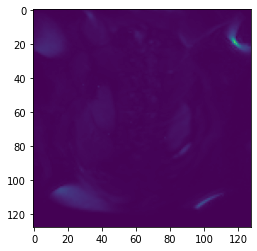

In [10]:
dwi_registration = MotionCorrection(pixel_array, affine_dwi, 'DWI_Moco', list_input_parameters_dwi, convergence=1, multithread=False, log=False, mask=mask_moco_dwi)

Extract and save the motion corrected DWI results.

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


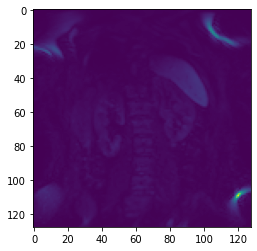

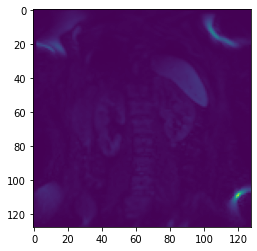

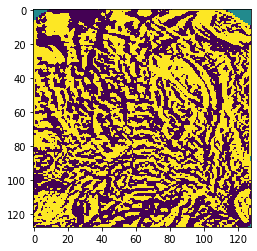

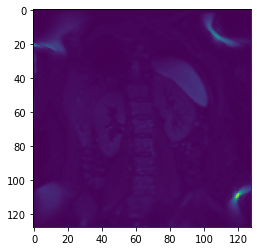

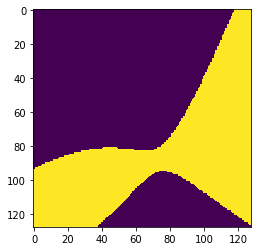

In [11]:
# Get the DWI coregistered pixel_array and the array with the difference between the original and the motion corrected
dwi_moco_array = dwi_registration.get_coregistered()
dwi_moco_diff_array = dwi_registration.get_diff_orig_coreg()
dwi_registration.get_elastix_parameters(output_directory=OUTPUT_DIR, base_file_name='DWI_Elastix', export=True)
dwi_registration.get_improvements(output_directory=OUTPUT_DIR, base_file_name='DWI_improvements', export=True)
# Save motion corrected diffusion sequence to NIfTI
dwi_registration.to_nifti(output_directory=OUTPUT_DIR, base_file_name='DWI_motion_corrected', maps=['original', 'coregistered', 'difference', 'mask', 'model_fit', 'deformation_field', 'parameters'])
dwi_registration.to_gif(output_directory=OUTPUT_DIR, base_file_name='DWI_motion_corrected', maps=['original', 'coregistered', 'difference', 'model_fit', 'deformation_field'])

Perform ADC and DTI calculation in the original and co-registered DWI images.

In [12]:
# Calculate maps from the original diffusion sequence using ADC methods and save as niftis
adc_mapper = ADC(pixel_array, affine_dwi, bvals, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps='all')

# Calculate maps from the original diffusion sequence using DTI methods and save as niftis
dti_mapper = DTI(pixel_array, affine_dwi, bvals, bvecs, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_original', maps=['md', 'fa'])

# Calculate maps from the motion corrected diffusion sequence using ADC methods and save as niftis
adc_mapper_moco = ADC(dwi_moco_array, affine_dwi, bvals, ukrin_b=True)
adc_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps='all')

# Calculate maps from the motion corrected diffusion sequence using DTI methods and save as niftis
dti_mapper_moco = DTI(dwi_moco_array, affine_dwi, bvals, bvecs, ukrin_b=True)
dti_mapper.to_nifti(output_directory=OUTPUT_DIR, base_file_name='diffusion_moco', maps=['md', 'fa'])

100%|██████████| 142232/142232 [00:18<00:00, 7643.50it/s]


Display the difference between the original DWI images and the co-registered images.

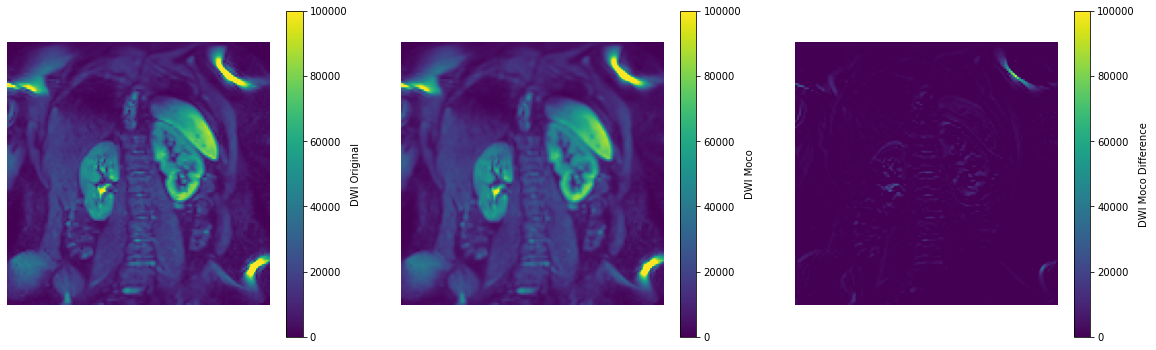

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Display the DWI original data
im = ax1.imshow(np.rot90(pixel_array[..., 4, 40]), clim=(0, 100000))
cb = fig.colorbar(im, ax=ax1)
cb.set_label('DWI Original')
ax1.axis('off')

# Display the DWI co-registered data
im2 = ax2.imshow(np.rot90(dwi_moco_array[..., 4, 40]), clim=(0, 100000))
cb = fig.colorbar(im2, ax=ax2)
cb.set_label('DWI Moco')
ax2.axis('off')

# Display the difference image between DWI original data and DWI co-registered data
im3 = ax3.imshow(np.rot90(dwi_moco_diff_array[..., 4, 40]), clim=(0, 100000))
cb = fig.colorbar(im3, ax=ax3)
cb.set_label('DWI Moco Difference')
ax3.axis('off')

plt.show()

Plot the ADC, MD and FA maps from the original images.

(-0.5, 127.5, 127.5, -0.5)

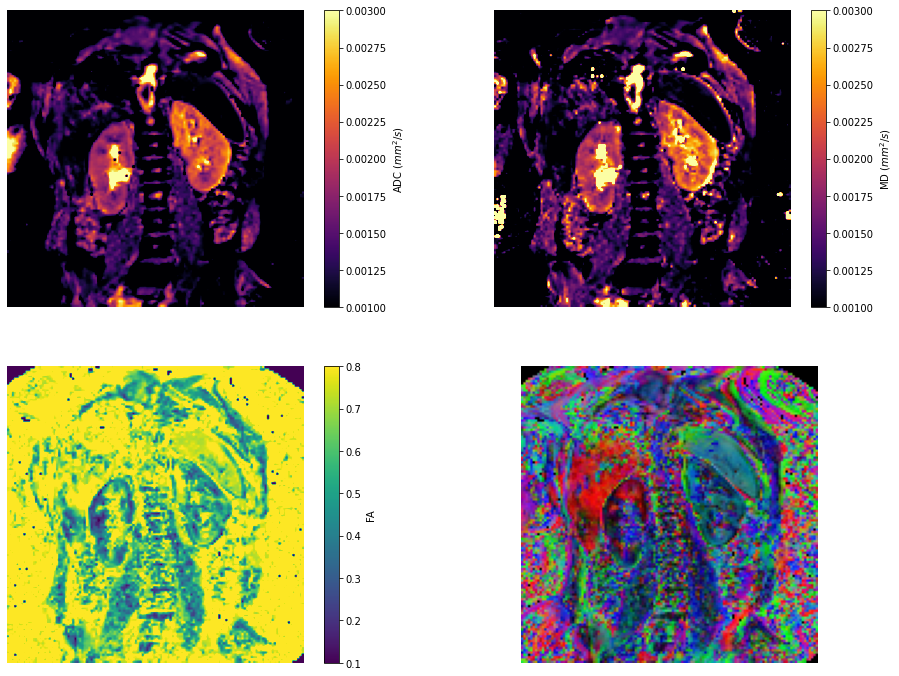

In [14]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper.adc[:, :, adc_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper.md[:, :, dti_mapper.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper.fa[:, :, dti_mapper.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper.color_fa[:, :, dti_mapper.shape[2]//2, :]))
ax[1, 1].axis('off')

Plot the ADC, MD and FA maps from the co-registered images.

(-0.5, 127.5, 127.5, -0.5)

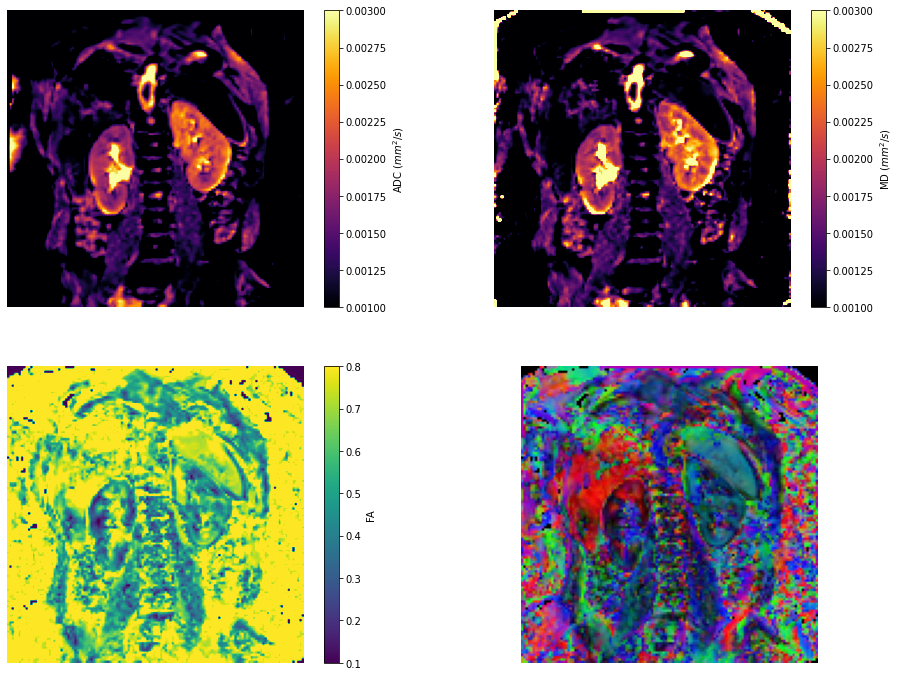

In [15]:
# Display the central slice of each map
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Display a central slice of the ADC map
im = ax[0, 0].imshow(np.rot90(adc_mapper_moco.adc[:, :, adc_mapper_moco.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 0])
cb.set_label('ADC ($mm^2/s$)')
ax[0, 0].axis('off')

# Display a central slice of the MD map
im = ax[0, 1].imshow(np.rot90(dti_mapper_moco.md[:, :, dti_mapper_moco.shape[2]//2]), cmap='inferno', clim=(0.001, 0.003))
cb = fig.colorbar(im, ax=ax[0, 1])
cb.set_label('MD ($mm^2/s$)')
ax[0, 1].axis('off')

# Display a central slice of the FA map
im = ax[1, 0].imshow(np.rot90(dti_mapper_moco.fa[:, :, dti_mapper_moco.shape[2]//2]), cmap='viridis', clim=(0.1, 0.8))
cb = fig.colorbar(im, ax=ax[1, 0])
cb.set_label('FA')
ax[1, 0].axis('off')

# Display a central slice of the color FA map
im = ax[1, 1].imshow(np.rot90(dti_mapper_moco.color_fa[:, :, dti_mapper_moco.shape[2]//2, :]))
ax[1, 1].axis('off')